# fast estimation of particle properties
Tim Tyree<br>
9.29.2021<br>
`conda activate pyenv_ub`

__TODO(later):__ bug mike to make certain that for the 99.95% accurate decoder, that the i^th neuron for the Match trials is the same as the i^th neuron for the Mismatch trials for all i neuron-units considered.

__GOAL__: efficiently generate an inline rendering of dRdt versus 1/R and MSD versus tau using dashly.  try the solution suggested on my stackoverflow post

In [1]:
from lib.my_initialization import *
from lib import *
# from lib.measure.unwrap_and_smooth_cu import *
# from lib.rapids_func import *
# .routines.unwrap_and_smooth_trajectories_cu import *

import itertools
import dask_cudf
from lib.rapids_func import *
get_DT_cu

#magic    
%autocall 1
%load_ext autoreload
%autoreload 2

import cupy as cp, cudf, numba.cuda as cuda
import rmm
# Switch to RMM allocator
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

Automatic calling is: Smart


In [2]:
darkmode=True
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# (optional) postprocess a token trajectory file
- Nota Bene: batch computation is already automated and optimized in 'fast postprocessing a list of trajectory folders.ipynb'

In [3]:
# input_fn=search_for_file()

# # #token FK at DT=0.4
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv"

# # #tokenLR at DT=0.5
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.31_traj_sr_600_mem_0.csv"
input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.11_traj_sr_600_mem_0.csv"

#test routine on one file
testing=False
if testing:
    df=pd.read_csv(input_fn)
    DT=np.around(get_DT(df),5);print(f"DT={DT}")
    # ds=5 #cm
    # DS=ds/width
    tavg1=4 #moving average window, in ms
    width=200
    height=width
    use_drop_shorter_than=True
    drop_shorter_than=50 #ms
    tmin=100.#ms
    pid_col='particle'
    t_col='t'
    printing=False
    navg1=int(tavg1/DT)
    save_dir=return_moving_average_of_pbc_trajectories_and_save(
            input_fn, tavg1, pid_col, t_col, DT, width, height,
            use_drop_shorter_than, drop_shorter_than, tmin, printing)
    print(save_dir)

    df=load_smoothed_trajectories(save_dir,pid_col,t_col)
    df.head()

In [4]:
#run the routine on a whole folder
# print((DT, input_fn))
# save_dir_lst=routine_postprocess_trajectory_folder(input_fn,DT,tavg1=4, npartitions=None,
#                                         width=200,
#                                         height=200,
#                                         use_drop_shorter_than=True,
#                                         drop_shorter_than=50, #ms
#                                         tmin=100., #ms
#                                         pid_col='particle',
#                                         t_col='t',
#                                         printing=False)

In [5]:
# #TODO(later): compute squared displacements
# grouped=df.groupby(pid_col)
# #HINT: squared displacements of particles is result
#  throws AttributeError: DataFrameGroupBy object has no attribute first 
# result = (grouped[['x','y']]-grouped[['x','y']].first())**2

In [6]:
#TODO(later): implement a one_step method on an element in a finite element simulation
# HINT: cudf.Grouper?
# HINT: https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#grouping-with-a-grouper-specification
# HINT: https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#transformation

# define module

In [7]:
# def get_DT_cu(df,t_col='t',pid_col='particle',round_digits=7):
#     pid_values=df[pid_col].drop_duplicates().values
#     return float(np.around(df.loc[pid_values[0]==df[pid_col],t_col].diff().tail(1).values.get(),round_digits))

In [8]:
# def comp_intersecting_pairs_cu(df,pid_col='particle',**kwargs):
#     '''returns a cudf.DataFrame instance that identifies pairs of particles that coexist along with their start and end times.
#     df is s cudf.DataFrame instance with columns tmin and tmax along with a unique index for each row and a particle id recorded in the column indicated by pid_col'''
#     dfff=df
#     index_values=dfff.index.values.get()
#     index_pair_values=cp.array(list(itertools.combinations(index_values, 2)))
#     tmin_self_values=dfff.loc[index_pair_values[:,0],'tmin'].values
#     tmax_self_values=dfff.loc[index_pair_values[:,0],'tmax'].values
#     tmin_other_values=dfff.loc[index_pair_values[:,1],'tmin'].values
#     tmax_other_values=dfff.loc[index_pair_values[:,1],'tmax'].values

#     boo_intersecting=(tmin_other_values<tmax_self_values) & (tmax_other_values>tmin_self_values)
#     intersecting_index_pair_values=index_pair_values[boo_intersecting]
#     intersecting_index_pair_values.shape

#     col_lst=[pid_col,'tmin','tmax']
#     df_self=dfff.loc[intersecting_index_pair_values[:,0],col_lst]
#     df_other=dfff.loc[intersecting_index_pair_values[:,1],col_lst]
#     df_intersecting_pairs=cudf.DataFrame({
#         'pid_self':df_self[pid_col].values,
#         'pid_other':df_other[pid_col].values,
#         'tmin_self':df_self['tmin'].values,
#         'tmin_other':df_other['tmin'].values,
#         'tmax_self':df_self['tmax'].values,
#         'tmax_other':df_other['tmax'].values,
#     })
#     df_intersecting_pairs['tmin']=df_intersecting_pairs[["tmin_self", "tmin_other"]].max(axis=1)
#     df_intersecting_pairs['tmax']=df_intersecting_pairs[["tmax_self", "tmax_other"]].min(axis=1)
#     df_intersecting_pairs['duration']=df_intersecting_pairs['tmax']-df_intersecting_pairs['tmin']
#     return df_intersecting_pairs

In [9]:
# #DONE: computes the dataframe identifying the largest start/end times for all pairs of particles
# #TODO: wrap all this into a function
# #TODO(later): add support to parallelize this over dask with npartitions determined locally.  measure any performance boost
# def identify_all_coexisting_pairs(df,pid_col='particle',t_col='t',trial_col='event_id_int',npartitions=None,use_dask=None,printing=True,**kwargs):
#     '''computes the dataframe identifying the largest start/end times for all pairs of particles
#     returns a cudf.DataFrame instance that identifies pairs of particles that coexist along with their start and end times, for all rows uniquely identified by trial_col
#     df is s cudf.DataFrame instance with columns tmin and tmax along with a unique index for each row and a particle id recorded in the column indicated by pid_col
#     option to parallelize this gpu accelerated task via dask with npartitions determined locally.  
#     Example Usage:
#     df_intersecting_pairs_all=identify_all_coexisting_pairs(df,pid_col='particle',t_col='t')
    
#     '''
#     dff=df
#     #iterate over all events and compute the dataframe identifying the largest start/end times for all pairs of particles
#     event_id_int_values=dff[trial_col].drop_duplicates().values
#     num_trials=event_id_int_values.get().shape[0]
#     #decide on cpu resource allocation
#     if npartitions is None:
#         npartitions=np.min((int(os.cpu_count()/2),num_trials))
#     if use_dask is None:
#         use_dask=npartitions>1

#     if printing:
#         print(f"using {npartitions} cores to identify pairs of particles that coexist over {event_id_int_values.shape[0]} independent trials...")

#     #DONE: 
#     #TODO(later): measure any performance boost
#     if not use_dask:
#         df_intersecting_pairs_lst=[]
#         for event_id_int in event_id_int_values.get():
#             dfff=dff[dff[trial_col]==event_id_int]
#             df_intersecting_pairs=comp_intersecting_pairs_cu(df=dfff,pid_col=pid_col,t_col=t_col)
#             #augment df_intersecting_pairs with any columns desired
#             df_intersecting_pairs[trial_col]=event_id_int
#             #record
#             df_intersecting_pairs_lst.append(df_intersecting_pairs)
#     else:
#         #define routine locally with dff baked
#         def routine(event_id_int):
#             try:
#                 dfff=dff[dff[trial_col]==event_id_int]
#                 df_intersecting_pairs=comp_intersecting_pairs_cu(df=dfff,pid_col=pid_col,t_col=t_col)
#                 #augment df_intersecting_pairs with any columns desired
#                 df_intersecting_pairs[trial_col]=event_id_int
#                 return df_intersecting_pairs
#             except Exception as e:
#                 return e
    
#         #feed routine to a daskbag
#         bag = db.from_sequence(list(event_id_int_values.get()), npartitions=npartitions).map(routine)
#         start = time.time()
#         df_intersecting_pairs_lst = list(bag)
#         if printing:
#             print(f"the run time was {(time.time()-start)/60:.2f} minutes.")
#             print(f"the number of successfully processed trials was {len(df_intersecting_pairs_lst)}")
#     df_intersecting_pairs_all=cudf.concat(df_intersecting_pairs_lst)
#     return df_intersecting_pairs_all

In [10]:
#DONE: figure out if there's an elegant was to use the cudf api  to do this
#for each group of event_id_int's :
#compare every particle to every other particle in a simple way
#compare every particle to every other particle to determine if the self,other pair intersects nontrivially

#DONE: determine condition for whether each pair is intersecting for at least two times 
# two particles exist for at least two times if both
#if other has a tmin > tmin of self
#AND if other has a tmax < tmax of self, 

# #DONE: construct the graph of all edges... this wasn't useful...
# G = cugraph.Graph()
# G.from_cudf_edgelist(df_pairs, source='src', destination='dst', edge_attr='dst')
# # # Let's now get the PageRank score of each vertex by calling cugraph.pagerank
# # df_page = cugraph.pagerank(G)
# # df_page.head()

In [11]:
#DONE: compute which edges are intersecting
#DONE: compute tmin and tmax for each intersecting edge
#DONE: compute duration for each intersecting edge
#DONE: sort edges by duration
#DONE: visualize the histogram of durations of intersecting edges
#DONE: consider a minimum_duration_threshold that is at least tavg2 if not specified

# TODO: compute dRdt versus 1/R for unconstrained random samples from smoothed and validated trajectories

__Note:__ cugraph is a great tool for complex problems that happen in terms of graphs that benefit from visualization.  My graph problem is low-level, and therefore it does not appear beneficial for me to use cugraph here.

In [12]:
#define parameters
trial_col='event_id_int'
pid_col='particle' 
t_col='t' 
width=200
height=200
tmin=100.
printing=True

tavg2=0.
minimum_duration_threshold=tavg2
minimum_duration_threshold=25 #ms

In [13]:
#recall a couple postprocessed single trials
input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectories_navg_8/ic002.11_traj_sr_600_mem_0_smoothed.csv"
input_fn2=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectories_navg_8/ic002.12_traj_sr_600_mem_0_smoothed.csv"
input_fn_lst=[input_fn,input_fn2]
df=dask_cudf.read_csv(input_fn_lst).compute()
type(df)

df=df.sort_values([trial_col,pid_col, t_col], ascending=True).copy()
DT=get_DT_cu(df,t_col,pid_col)
navg2=int(tavg2/DT)
if printing:
    print(f"DT={DT} ms")

DT=0.5 ms


In [14]:
#compute the intermediate dataframe of particle start/end times
grouped=df.groupby([trial_col,pid_col])
dft=grouped[t_col]
dff=cudf.DataFrame({
    'tmin':dft.min(),
    'tmax':dft.max(),
})
dff.reset_index(inplace=True)
# dff.head()

In [15]:
df_intersecting_pairs_all=identify_all_coexisting_pairs(df=dff,pid_col=pid_col,t_col=t_col,trial_col=trial_col)
df_intersecting_pairs_all.head()

using 6 cores to identify pairs of particles that coexist over 2 independent trials...
the run time was 0.09 minutes.
the number of successfully processed trials was 2


,pid_self,pid_other,tmin_self,tmin_other,tmax_self,tmax_other,tmin,tmax,duration,event_id_int
0,5035,5038,8684.5,8707.5,8740.5,8769.5,8707.5,8740.5,33.0,1002116000
1,5035,5037,8684.5,8693.0,8740.5,8769.5,8693.0,8740.5,47.5,1002116000
2,5035,5040,8684.5,8707.5,8740.5,8801.5,8707.5,8740.5,33.0,1002116000
3,5035,5061,8684.5,8727.0,8740.5,8843.0,8727.0,8740.5,13.5,1002116000
4,5035,4976,8684.5,8586.0,8740.5,8693.0,8684.5,8693.0,8.5,1002116000


In [16]:
#test that duration is strictly positive
assert ( (df_intersecting_pairs_all['duration']>0).all() )
if printing:
    print (f"verified that the duration is strictly positive for all pairs of tips that coexist nontrivially")

verified that the duration is strictly positive for all pairs of tips that coexist nontrivially


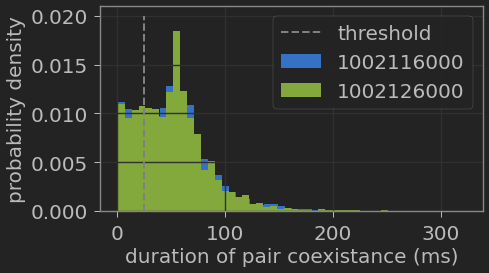

In [17]:
#plot histogram of durations
fontsize=20
#DONE: histograms sanity check df_intersecting_pairs
#DONE: verify that routine gives different values for different event_id_int
fig,ax=plt.subplots(figsize=(7,4))
yv=np.linspace(0,0.02,10)
ax.plot(minimum_duration_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')
trial_col_lst=sorted(df_intersecting_pairs_all[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    df_intersecting_pairs_all.query(f"{trial_col} == {trial}")['duration'].to_pandas().hist(density=True,bins=50,ax=ax,label=trial)#,color='event_id_int')
format_plot(ax, xlabel='duration of pair coexistance (ms)', ylabel='probability density', fontsize=fontsize, use_loglog=False)

ax.legend(fontsize=fontsize)
plt.tight_layout()
plt.show()
#DONE: wrap generation of df_intersecting_pairs into a function 
#DONE: include event_id_int outside ^that function
#DONE: accumulate df_intersecting_pairs_all over all event_id_int_values

In [18]:
#filter by duration_threshold
use_duration_threshold=True
if use_duration_threshold:
    pass
df_pairs=df_intersecting_pairs_all[df_intersecting_pairs_all['duration']>minimum_duration_threshold]
#TODO:compute the distance in x between any points where two spiral tips occur at the same time in t
#is the best way to do this to project to cupy and to run all rows in  together in a daskbag?
print(df.head().columns)
print(df_pairs.head().columns)

Index(['index', 'x', 'y', 't', 'particle', 'event_id_int', 'dx_unwrap',
       'dy_unwrap'],
      dtype='object')
Index(['pid_self', 'pid_other', 'tmin_self', 'tmin_other', 'tmax_self',
       'tmax_other', 'tmin', 'tmax', 'duration', 'event_id_int'],
      dtype='object')


In [19]:
df_intersecting_pairs_all.head()

,pid_self,pid_other,tmin_self,tmin_other,tmax_self,tmax_other,tmin,tmax,duration,event_id_int
0,5035,5038,8684.5,8707.5,8740.5,8769.5,8707.5,8740.5,33.0,1002116000
1,5035,5037,8684.5,8693.0,8740.5,8769.5,8693.0,8740.5,47.5,1002116000
2,5035,5040,8684.5,8707.5,8740.5,8801.5,8707.5,8740.5,33.0,1002116000
3,5035,5061,8684.5,8727.0,8740.5,8843.0,8727.0,8740.5,13.5,1002116000
4,5035,4976,8684.5,8586.0,8740.5,8693.0,8684.5,8693.0,8.5,1002116000


In [20]:
#TODO(IMMEDIATE FOLLOWUP GOAL): show how insensitive a is to choice in navg1 (and/or navg2 if I'm using it!)
#GOAL_QUESTION: does there exist a tavg1 that produces the right expected a for a single termination event??

In [21]:
#TODO: estimate an ensemble averaged a estimate
#TODO: augment df_interacting_pairs with estimates for a for individual pairs of particles
#TODO: use ^that to filter based on Rsq or Delta_a and recompute an ensemble averaged a estimate